# Load the Required Libraries

In [4]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import load_img, img_to_array
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt



# Dataloader Class

In [6]:
class DataLoader:
    def __init__(self, path, img_size):
        self.dataset_path = path
        self.img_size = img_size
        self.images = []
        self.labels = []
        self.class_names = []

    def load_data(self):
        self.class_names = sorted(os.listdir(self.dataset_path))
        for label, class_name in enumerate(self.class_names):
            class_folder = os.path.join(self.dataset_path, class_name)
            for img_file in os.listdir(class_folder):
                img_path = os.path.join(class_folder, img_file)
                try:
                    img = load_img(img_path, target_size=self.img_size)
                    img_array = img_to_array(img)
                    self.images.append(img_array)
                    self.labels.append(label)
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")

        self.images = np.array(self.images, dtype='float32') / 255.0  
        self.labels = np.array(self.labels)
        print(f"Loaded {len(self.images)} images with {len(self.class_names)} classes.")

    def get_train_test_split(self, test_size=0.3):
        x_train, x_test, y_train, y_test = train_test_split(
            self.images, self.labels, test_size=test_size, random_state=42
        )

        y_train = to_categorical(y_train, len(self.class_names))
        y_test = to_categorical(y_test, len(self.class_names))
        return x_train, x_test, y_train, y_test


# Model Class

In [7]:
class CNNModel:
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = None

    def build_model(self):

        self.model = Sequential([
            Conv2D(32, (3, 3), activation='relu', input_shape=self.input_shape),
            MaxPooling2D(pool_size=(2, 2)),
            Conv2D(64, (3, 3), activation='relu'),
            MaxPooling2D(pool_size=(2, 2)),
            Conv2D(128, (3, 3), activation='relu'),
            MaxPooling2D(pool_size=(2, 2)),
            Flatten(),
            Dense(256, activation='relu'),
            Dropout(0.5),
            Dense(self.num_classes, activation='softmax')
        ])
        print("Built")

    def compile_model(self):
        # Compile the model
        self.model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        print("Compiled")

    def train_model(self, x_train, y_train, x_val, y_val, epochs=10, batch_size=32):
        history = self.model.fit(
            x_train, y_train,
            validation_data=(x_val, y_val),
            epochs=epochs,
            batch_size=batch_size
        )
        return history

    def evaluate_model(self, x_test, y_test):
        results = self.model.evaluate(x_test, y_test)
        print(f"Test Loss: {results[0]:.4f}, Test Accuracy: {results[1]:.4f}")
    
    def calculate_metrics(self, x_test, y_test, class_names):
        y_pred = np.argmax(self.model.predict(x_test), axis=1)
        y_true = np.argmax(y_test, axis=1)
        
        # Confusion Matrix
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
        plt.title("Confusion Matrix")
        plt.ylabel("True Labels")
        plt.xlabel("Predicted Labels")
        plt.show()

        # Classification Report
        report = classification_report(y_true, y_pred, target_names=class_names)
        print("Classification Report:\n", report)
    
    def plot_training_history(self, history):
        # Extract loss and accuracy
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs = range(1, len(acc) + 1)

        # Plot Accuracy
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, acc, label='Training Accuracy')
        plt.plot(epochs, val_acc, label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        # Plot Loss
        plt.subplot(1, 2, 2)
        plt.plot(epochs, loss, label='Training Loss')
        plt.plot(epochs, val_loss, label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.show()

# Main Class

In [8]:
class Main:
    def __init__(self, dataset_path, img_size=(128, 128)):
        self.dataset_path = dataset_path
        self.img_size = img_size

    def run(self):
        # Data loading and preprocessing
        data_loader = DataLoader(self.dataset_path, self.img_size)
        data_loader.load_data()
        x_train, x_test, y_train, y_test = data_loader.get_train_test_split()

        # Model creation and training
        cnn_model = CNNModel(input_shape=self.img_size + (3,), num_classes=len(data_loader.class_names))
        cnn_model.build_model()
        cnn_model.compile_model()
        history = cnn_model.train_model(x_train, y_train, x_test, y_test, epochs=10, batch_size=32)
        
        # Plot training history
        cnn_model.plot_training_history(history)
        
        # Model evaluation and metrics
        cnn_model.evaluate_model(x_test, y_test)
        cnn_model.calculate_metrics(x_test, y_test, data_loader.class_names)



# Run the program

Error loading 256_ObjectCategories/056.dog/greg: [Errno 21] Is a directory: '256_ObjectCategories/056.dog/greg'
Error loading 256_ObjectCategories/198.spider/RENAME2: cannot identify image file <_io.BytesIO object at 0x17593bb50>
Loaded 30607 images with 257 classes.


/opt/miniconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Built
Compiled
Epoch 1/10
670/670 ━━━━━━━━━━━━━━━━━━━━ 335s 496ms/step - accuracy: 0.0423 - loss: 5.4106 - val_accuracy: 0.1070 - val_loss: 4.8195
Epoch 2/10
670/670 ━━━━━━━━━━━━━━━━━━━━ 325s 486ms/step - accuracy: 0.1087 - loss: 4.7663 - val_accuracy: 0.1807 - val_loss: 4.3437
Epoch 3/10
670/670 ━━━━━━━━━━━━━━━━━━━━ 314s 468ms/step - accuracy: 0.1601 - loss: 4.2679 - val_accuracy: 0.2154 - val_loss: 3.9881
Epoch 4/10
670/670 ━━━━━━━━━━━━━━━━━━━━ 309s 461ms/step - accuracy: 0.2115 - loss: 3.8439 - val_accuracy: 0.2301 - val_loss: 3.8384
Epoch 5/10
670/670 ━━━━━━━━━━━━━━━━━━━━ 321s 480ms/step - accuracy: 0.2664 - loss: 3.4159 - val_accuracy: 0.2455 - val_loss: 3.7649
Epoch 6/10
670/670 ━━━━━━━━━━━━━━━━━━━━ 303s 452ms/step - accuracy: 0.3336 - loss: 2.9723 - val_accuracy: 0.2492 - val_loss: 3.7848
Epoch 7/10
670/670 ━━━━━━━━━━━━━━━━━━━━ 301s 449ms/step - accuracy: 0.3932 - loss: 2.6122 - val_accuracy: 0.2508 - val_loss: 3.8080
Epoch 8/10
670/670 ━━━━━━━━━━━━━━━━━━━━ 296s 442ms/step - acc

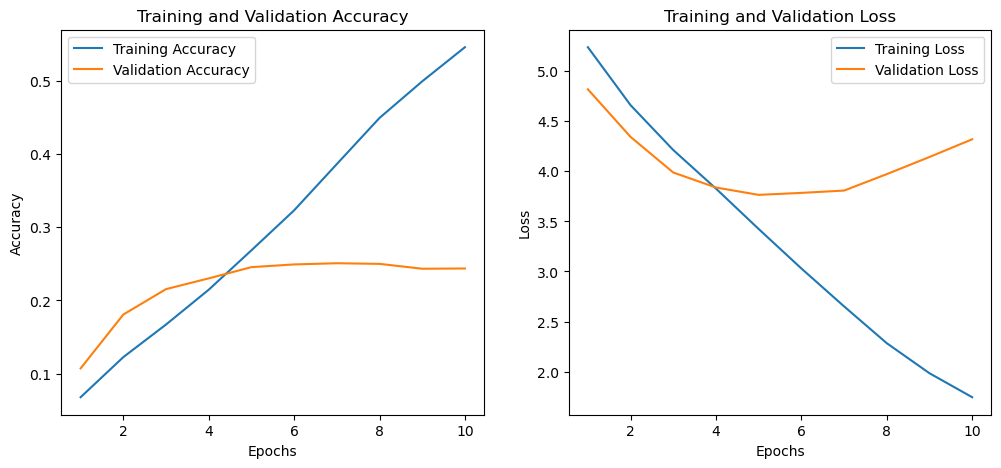

287/287 ━━━━━━━━━━━━━━━━━━━━ 31s 109ms/step - accuracy: 0.2382 - loss: 4.3343
Test Loss: 4.3203, Test Accuracy: 0.2436
287/287 ━━━━━━━━━━━━━━━━━━━━ 36s 124ms/step


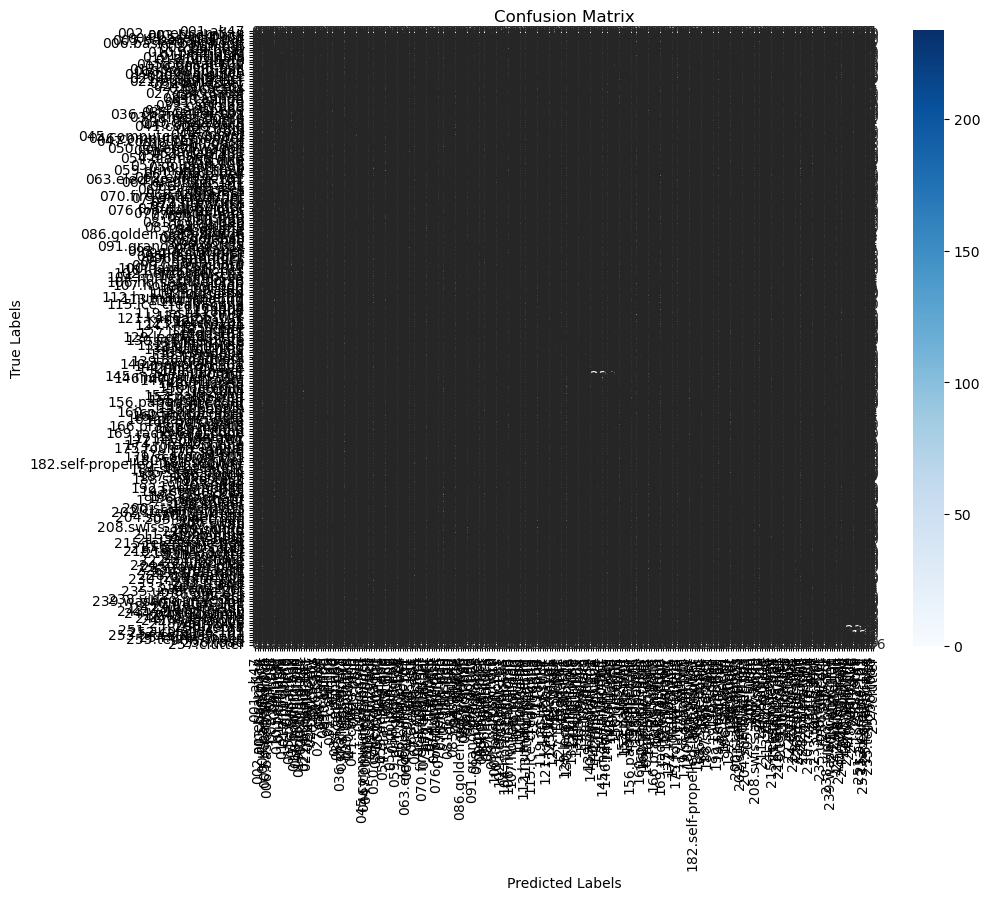

Classification Report:
                                precision    recall  f1-score   support

                     001.ak47       0.00      0.00      0.00        25
            002.american-flag       0.42      0.31      0.36        26
                 003.backpack       0.22      0.27      0.24        52
             004.baseball-bat       0.35      0.18      0.24        39
           005.baseball-glove       0.26      0.29      0.27        41
          006.basketball-hoop       0.00      0.00      0.00        25
                      007.bat       0.00      0.00      0.00        34
                  008.bathtub       0.12      0.14      0.13        63
                     009.bear       0.00      0.00      0.00        29
                 010.beer-mug       0.06      0.05      0.05        21
                011.billiards       0.16      0.22      0.19        99
               012.binoculars       0.33      0.56      0.42        61
                 013.birdbath       0.11      0.06  

In [9]:
if __name__ == "__main__":
    dataset_path = "256_ObjectCategories"
    main = Main(dataset_path)
    main.run()